# CNL (In context learning'de ensemble)

In [ ]:
!pip install torch transformers datasets

  Using cached torch-2.5.1-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached huggingface_hub-0.27.0-py3-none-any.whl.metadata (13 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.4.5-cp311-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\ahmed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### Imports, Set Path and Constant Values

In [ ]:
import sys
import os

# Set Constants
# If use Google Colab
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/CNL"
    sys.path.append(os.path.join(ROOT_PATH, 'src'))
    device = "cuda"
else:
    ROOT_PATH = "G:\Drive'ım\Colab Notebooks\CNL"
    device = "cpu"

CACHE_PATH = os.path.join(ROOT_PATH, 'cache')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw/v3')

# Create Folders
os.makedirs(RAW_DATA_PATH, exist_ok=True)
os.makedirs(CACHE_PATH, exist_ok=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
#from src.utils import missing_values #if not use Colab use this.
from utils import missing_values
import torch

from transformers import pipeline
from sklearn.utils import shuffle

#from datasets import load_dataset

### Load Datasets & Show Metadata, Shape and Missing Table

#### ARC-TR

Bu veri kümesi, bilimsel sorgulama ve mantık yürütme becerilerini ölçmeye yönelik hazırlanmıştır. İçerdiği sorular, genellikle bilimsel bilgiler gerektirir ve çoğu zaman çıkarımsal düşünmeyi zorunlu kılar.

In [ ]:
arc_dataset = load_dataset("malhajar/arc-tr-v0.2", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1172 [00:00<?, ? examples/s]

In [ ]:
df_arc = arc_dataset.to_pandas()
df_arc.head()

,id,question,choices,answerKey
0,Mercury_7175875,"Bir gökbilimci, bir göktaşının çarpmasından so...","{'label': ['A', 'B', 'C', 'D'], 'text': ['Geze...",C
1,Mercury_SC_409171,"Bir grup mühendis, farklı bina tasarımlarının ...","{'label': ['A', 'B', 'C', 'D'], 'text': ['bina...",B
2,Mercury_SC_408547,Fotosentez sürecinin nihai sonucu şeker ve oks...,"{'label': ['A', 'B', 'C', 'D'], 'text': ['Kimy...",C
3,Mercury_407327,"Bir fizikçi, bir arabanın bir rampadan atlamak...","{'label': ['A', 'B', 'C', 'D'], 'text': ['kont...",D
4,MCAS_2006_9_44,Bir astronot Ay'a 1.0 kg'lık bir cisim ve 5.0 ...,"{'label': ['A', 'B', 'C', 'D'], 'text': ['Her ...",D


In [ ]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1172 non-null   object
 1   question   1172 non-null   object
 2   choices    1172 non-null   object
 3   answerKey  1172 non-null   object
dtypes: object(4)
memory usage: 36.8+ KB


In [ ]:
df_arc.shape

(1172, 4)

In [ ]:
missing_values(df=df_arc, threshold=0, asc_sorting=False)

,Count,Percent
Columns,,
id,0,0.0
question,0,0.0
choices,0,0.0
answerKey,0,0.0


#### HELLASWAG-TR

Bu veri kümesi, dil modelinin bağlamsal anlam çıkarmadaki başarısını ölçmek için geliştirilmiştir. Veri kümesi, bir bağlam cümlesini tamamlamak için en uygun seçeneği seçmeyi gerektirir. Bu özellik, dil modelinin bağlamsal bütünlüğü koruma ve mantıksal devamlılık sağlama yeteneklerini değerlendirmek için kullanılmıştır.

In [ ]:
hellaswag_dataset = load_dataset("malhajar/hellaswag-tr", split="train")

README.md:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

hellaswag_train_14740.jsonl:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

hellaswag_train_39904.jsonl:   0%|          | 0.00/55.5M [00:00<?, ?B/s]

hellaswag_validation_10041.jsonl:   0%|          | 0.00/18.1M [00:00<?, ?B/s]

hellaswag_test_10002.jsonl:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

hellaswag_test_2144.jsonl:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
df_hellas = hellaswag_dataset.to_pandas()
df_hellas.head()

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label
0,8,Kurabiye pişirmek,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",tavalar,"Beyaz üniformalı bir kadın şef, büyük bir mutf...","[yumurta sarısı ve kabartma tozu içerir., daha...",activitynet~v_-2dxp-mv2zo,train,indomain,3
1,9,Kurabiye pişirmek,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",Bir bıçak,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",[bir tahta üzerinde hareket ettiği ve içindeki...,activitynet~v_-2dxp-mv2zo,train,indomain,3
2,12,Kurabiye pişirmek,Fırına bir tepsi patates konulur ve çıkarılır....,büyük bir tepsi et,Fırına bir tepsi patates konulur ve çıkarılır....,"[fırında patatesin üzerine yerleştirilir., , l...",activitynet~v_-2dxp-mv2zo,train,indomain,3
3,27,Saç kestirmek,Ortadaki adam mavi gömlek giyen kişinin saç st...,mavi gömlekli adam,Ortadaki adam mavi gömlek giyen kişinin saç st...,[mavi gömlek giyen kişinin saçını kesen sünger...,activitynet~v_-JqLjPz-07E,train,indomain,2
4,29,Saç kestirmek,Mavi gömlekli adam lavabonun yanındaki sandaly...,o,Mavi gömlekli adam lavabonun yanındaki sandaly...,"[su musluğunu lavaboya düşürür., sonra lavaboy...",activitynet~v_-JqLjPz-07E,train,indomain,3


In [ ]:
df_hellas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39902 entries, 0 to 39901
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ind             39902 non-null  int32 
 1   activity_label  39902 non-null  object
 2   ctx_a           39902 non-null  object
 3   ctx_b           39902 non-null  object
 4   ctx             39902 non-null  object
 5   endings         39902 non-null  object
 6   source_id       39902 non-null  object
 7   split           39902 non-null  object
 8   split_type      39902 non-null  object
 9   label           39902 non-null  object
dtypes: int32(1), object(9)
memory usage: 2.9+ MB


In [ ]:
df_hellas.shape

(39902, 10)

In [ ]:
missing_values(df=df_hellas, threshold=0, asc_sorting=False)

,Count,Percent
Columns,,
ind,0,0.0
activity_label,0,0.0
ctx_a,0,0.0
ctx_b,0,0.0
ctx,0,0.0
endings,0,0.0
source_id,0,0.0
split,0,0.0
split_type,0,0.0


#### GSM8K-TR

Özellikle matematiksel problem çözme ve mantıksal akıl yürütme becerilerini test etmek amacıyla tasarlanmış 8,790 soru ve cevap çiftinden oluşmaktadır. Cevap olarak her bir sorunun açıklamalı bir şekilde tüm işlem adımları detaylıca ifade edildikten sonra nihai cevap verilmiştir.

In [ ]:
gsm8k_dataset = load_dataset("malhajar/gsm8k_tr-v0.2", split="test")

README.md:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/473k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1317 [00:00<?, ? examples/s]

In [ ]:
df_gsm8k = gsm8k_dataset.to_pandas()
df_gsm8k.head()

,question,answer
0,Janet'in ördekleri günde 16 yumurta yapar. Her...,Janet her gün 16 yumurta yapar. Her sabah kahv...
1,Bir cübbe için 2 top mavi lif ve bunun yarısı ...,Bir cübbe için 2 top mavi lif gerekiyor ve bey...
2,Josh bir evi yenileyip satmaya karar verir. 80...,Josh'un ev ve onarım masrafları toplamda 80.00...
3,James haftada 3 kez 3 sprint koşmaya karar ver...,"James haftada 3 gün, her gün 3 sprint koşmaya ..."
4,"Her gün Wendi, tavuklarını sağlıklı tutmak içi...",Her bir tavuğun günde 3 bardak yem yediğini dü...


In [ ]:
df_gsm8k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1317 non-null   object
 1   answer    1317 non-null   object
dtypes: object(2)
memory usage: 20.7+ KB


In [ ]:
df_gsm8k.shape

(1317, 2)

In [ ]:
missing_values(df=df_gsm8k, threshold=0, asc_sorting=False)

,Count,Percent
Columns,,
question,0,0.0
answer,0,0.0


In [ ]:
# Preprocessing: Soru ve nihai cevabı ayrıştır
def preprocess_gsm8k(example):
    # Soru
    question = example["question"]
    # Nihai cevabı al ("####" işaretinden sonraki kısmı ayrıştır)
    if "####" in example["answer"]:
        final_answer = example["answer"].split("####")[-1].strip()
    else:
        final_answer = example["answer"]  # Eğer "####" yoksa tüm metni alır
    return {"question": question, "answer": final_answer}

In [ ]:
gsm8k_preprocessed = gsm8k_dataset.map(preprocess_gsm8k)
gsm8k_df = pd.DataFrame(gsm8k_preprocessed)
gsm8k_df.to_csv(os.path.join(RAW_DATA_PATH, "gsm8k_cleaned.csv"), index=False, encoding='utf-8')

In [ ]:
gsm8k_df.head()

,question,answer
0,Janet'in ördekleri günde 16 yumurta yapar. Her...,18
1,Bir cübbe için 2 top mavi lif ve bunun yarısı ...,3
2,Josh bir evi yenileyip satmaya karar verir. 80...,70000
3,James haftada 3 kez 3 sprint koşmaya karar ver...,540
4,"Her gün Wendi, tavuklarını sağlıklı tutmak içi...",20


### Preprocessing question with choices

In [ ]:
def preprocess_arc_with_choices(example):
    """
    ARC veri kümesinde question sütunu olarak soru ve şıkları alıyoruz.
    """
    choices = example["choices"]["text"]
    correct_index = example["choices"]["label"].index(example["answerKey"])
    correct_answer = choices[correct_index]

    formatted_choices = "\n".join([f"{chr(65 + idx)}. {choice}" for idx, choice in enumerate(choices)])

    return {
        "question": f"{example['question']}\nŞıklar:\n{formatted_choices}",
        "answerKey": example["answerKey"],
        "answer": correct_answer
    }

arc_dataset_with_choices = arc_dataset.map(preprocess_arc_with_choices)

arc_with_choices_df = pd.DataFrame(arc_dataset_with_choices)
arc_cleaned = arc_with_choices_df[["question", "answer", "answerKey"]]
arc_cleaned.to_csv(os.path.join(RAW_DATA_PATH, "arc_cleaned_with_choices.csv"), index=False, encoding='utf-8')

In [ ]:
arc_cleaned.head()

,question,answer,answerKey
0,"Bir gökbilimci, bir göktaşının çarpmasından so...",Gezegensel günler kısalacak.,C
1,"Bir grup mühendis, farklı bina tasarımlarının ...",binalar daha güvenli hale getirilecek,B
2,Fotosentez sürecinin nihai sonucu şeker ve oks...,Yapraktaki klorofil ışık enerjisini yakalar.,C
3,"Bir fizikçi, bir arabanın bir rampadan atlamak...",bağımsız (manipüle edilen) değişken,D
4,Bir astronot Ay'a 1.0 kg'lık bir cisim ve 5.0 ...,Her biri maksimum kinetik enerjilerinin yarısı...,D


In [ ]:
def preprocess_hellaswag_with_choices(example):
    """
    Hellaswag için question sütunu olarak ctx ve endings'leri alıyoruz.
    """
    choices = example["endings"]
    correct_answer = choices[int(example["label"])]
    correct_answer_idx = int(example["label"])

    formatted_choices = "\n".join([f"{chr(65 + idx)}. {choice}" for idx, choice in enumerate(choices)])

    correct_answer_choice = chr(65 + correct_answer_idx)

    return {
        "question": f"{example['ctx']}\nŞıklar:\n{formatted_choices}",
        "answerKey": correct_answer_choice,
        "answer": correct_answer

    }

hellaswag_dataset_with_choices = hellaswag_dataset.map(preprocess_hellaswag_with_choices)

hellaswag_with_choices_df = pd.DataFrame(hellaswag_dataset_with_choices)
hellaswag_cleaned = hellaswag_with_choices_df[["question", "answer", "answerKey"]]
hellaswag_cleaned.to_csv(os.path.join(RAW_DATA_PATH, "hellaswag_cleaned_with_choices.csv"), index=False, encoding='utf-8')

Map:   0%|          | 0/39902 [00:00<?, ? examples/s]

In [ ]:
hellaswag_cleaned.head()

,question,answer,answerKey
0,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",hamur işleri ile doldurulur ve fırına yüklenir.,D
1,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",Silindir şeklindeki hamurların yuvarlak şekild...,D
2,Fırına bir tepsi patates konulur ve çıkarılır....,Hazırlandıktan sonra bir yardımcı tarafından f...,D
3,Ortadaki adam mavi gömlek giyen kişinin saç st...,lavabonun yanındaki sandalyeye oturuyor.,C
4,Mavi gömlekli adam lavabonun yanındaki sandaly...,şampuanla ovalar ve sonra yıkar.,D


### Load Preprocessed & Cleaned Datasets From CSV : Arc, Hellaswag, GSM8K

In [ ]:
arc_csv_path = os.path.join(RAW_DATA_PATH, "arc_cleaned_with_choices.csv")
hellaswag_csv_path = os.path.join(RAW_DATA_PATH, "hellaswag_cleaned_with_choices.csv")
gsm8k_csv_path = os.path.join(RAW_DATA_PATH, "gsm8k_cleaned.csv")

In [ ]:
df_arc_cleaned = pd.read_csv(arc_csv_path)
df_hellaswag_cleaned = pd.read_csv(hellaswag_csv_path)
df_gsm8k_cleaned = pd.read_csv(gsm8k_csv_path)

In [ ]:
df_arc_cleaned.head()

,question,answer,answerKey
0,"Bir gökbilimci, bir göktaşının çarpmasından so...",Gezegensel günler kısalacak.,C
1,"Bir grup mühendis, farklı bina tasarımlarının ...",binalar daha güvenli hale getirilecek,B
2,Fotosentez sürecinin nihai sonucu şeker ve oks...,Yapraktaki klorofil ışık enerjisini yakalar.,C
3,"Bir fizikçi, bir arabanın bir rampadan atlamak...",bağımsız (manipüle edilen) değişken,D
4,Bir astronot Ay'a 1.0 kg'lık bir cisim ve 5.0 ...,Her biri maksimum kinetik enerjilerinin yarısı...,D


In [ ]:
df_hellaswag_cleaned.head()

,question,answer,answerKey
0,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",hamur işleri ile doldurulur ve fırına yüklenir.,D
1,"Beyaz üniformalı bir kadın şef, büyük bir mutf...",Silindir şeklindeki hamurların yuvarlak şekild...,D
2,Fırına bir tepsi patates konulur ve çıkarılır....,Hazırlandıktan sonra bir yardımcı tarafından f...,D
3,Ortadaki adam mavi gömlek giyen kişinin saç st...,lavabonun yanındaki sandalyeye oturuyor.,C
4,Mavi gömlekli adam lavabonun yanındaki sandaly...,şampuanla ovalar ve sonra yıkar.,D


In [ ]:
df_gsm8k_cleaned.head()

,question,answer
0,Janet'in ördekleri günde 16 yumurta yapar. Her...,18
1,Bir cübbe için 2 top mavi lif ve bunun yarısı ...,3
2,Josh bir evi yenileyip satmaya karar verir. 80...,70000
3,James haftada 3 kez 3 sprint koşmaya karar ver...,540
4,"Her gün Wendi, tavuklarını sağlıklı tutmak içi...",20


### Split Data

Bağlam için 10 adet örnek,
Tahmin için aynı 10 bağlam örneğini içermeyen 400 adet örnek olarak split ediliyor. Ayrıca soru uzunlukları çok fazla olan örnekler model tahmininde max_new_token = 256 sınırına takılacağı için uzunluğu 250 ve daha az olan örnekler kullanılmaktadır.

In [ ]:
def split_dataset(df, context_size=10, eval_size=400, output_prefix="dataset", max_question_length=250):

    # Soruları maksimum uzunluğa göre filtrele
    filtered_df = df[df["question"].apply(len) <= max_question_length]

    if len(filtered_df) < context_size + eval_size:
        raise ValueError(
            f"Yeterli veri yok! {len(filtered_df)} örnek mevcut ancak {context_size + eval_size} gerekiyor."
        )

    df_shuffled = shuffle(filtered_df, random_state=42).reset_index(drop=True)
    context_data = df_shuffled.iloc[:context_size]
    eval_data = df_shuffled.iloc[context_size:context_size + eval_size]

    context_data.to_csv(os.path.join(RAW_DATA_PATH, f"{output_prefix}_context.csv"), index=False, encoding='utf-8')
    eval_data.to_csv(os.path.join(RAW_DATA_PATH, f"{output_prefix}_eval.csv"), index=False, encoding='utf-8')

    return context_data, eval_data

In [ ]:
arc_context, arc_eval = split_dataset(df_arc_cleaned, output_prefix="arc")

In [ ]:
hellaswag_context, hellaswag_eval = split_dataset(df_hellaswag_cleaned, output_prefix="hellaswag")

In [ ]:
gsm8k_context, gsm8k_eval = split_dataset(df_gsm8k_cleaned, output_prefix="gsm8k")

In [ ]:
arc_context

,question,answer,answerKey
0,En fazla yer kaplayan nesne hangisidir?\nŞıkla...,bir galaksi,A
1,Hangi vücut sistemi beyni darbe almaktan korur...,iskelet sistemi,C
2,Hangisi hem karışımı hem de çözeltiyi en iyi ş...,İki farklı madde birleşir.,B
3,DNA'da sitozinin tamamlayıcı bazı nedir?\nŞıkl...,guanin,C
4,Eğrelti otu bitkileri en çok nerede yetişir?\n...,bir nehir boyunca,B
5,Bir grafikteki yatay eksen x eksenidir. Bu eks...,bağımsız değişkenler,D
6,Bir mobilya şirketinin hangi bölümü mobilyalar...,dağıtım,A
7,Bir bitkinin büyüme ve gelişme aşamalarının do...,tohum -> genç bitki -> olgun bitki,C
8,Hangisi kimyasal bir değişimi gösterir?\nŞıkla...,paslanan bir çöp tenekesi,B
9,Bir lastik bant gerildiğinde hangi özelliği ay...,kütle,C


In [ ]:
arc_eval

,question,answer,answerKey
10,Periyodik tabloda hangi grup en az reaktif ola...,Grup 18 (8A),D
11,Hangi ifade bilimsel bir keşfin olumlu etkisin...,İşlerin nasıl yürüdüğünü açıklamaya yardımcı o...,C
12,Aşağıdakilerden hangisi televizyon yapımında k...,bozuk televizyonu onarmak,A
13,Çekirdeğini kaybetmiş bir hücre artık aşağıdak...,genetik bilgiyi aktarmak.,B
14,Geçiş fosilleri en iyi neyi destekler?\nŞıklar...,Biyolojik Evrim Teorisi,A
...,...,...,...
405,Bir katının sıvıya dönüşmesine bir örnek hangi...,buzun suya dönüşmesi.,C
406,"Azot döngüsünde, azot aşağıdaki yollarla doğru...",yıldırım.,A
407,Su hangi sıcaklıkta donar?\nŞıklar:\nA. 0 sant...,0 santigrat derece,A
408,"Mücevher yapımında kullanılan parlak, şekillen...",Grup 11 (1B),C


### Load splitted data (if require after first split)

In [ ]:
def load_splitted_data(output_prefix, output_path="RAW_DATA_PATH"):

    context_path = os.path.join(output_path, f"{output_prefix}_context.csv")
    test_path = os.path.join(output_path, f"{output_prefix}_eval.csv")

    context_samples = pd.read_csv(context_path)
    test_samples = pd.read_csv(test_path)

    print(f"{output_prefix} veri kümesi yüklendi.")
    return context_samples, test_samples

In [ ]:
arc_context, arc_eval = load_splitted_data("arc", output_path=RAW_DATA_PATH)
hellaswag_context, hellaswag_eval = load_splitted_data("hellaswag", output_path=RAW_DATA_PATH)
gsm8k_context, gsm8k_eval = load_splitted_data("gsm8k", output_path=RAW_DATA_PATH)

arc veri kümesi yüklendi.
hellaswag veri kümesi yüklendi.
gsm8k veri kümesi yüklendi.


### Bağlam Oluşturma & Prediction

In [ ]:
def generate_prompt_short(context_examples, eval_question):

    prompt = ""
    for i, row in enumerate(context_examples.itertuples(), 1):
        prompt += f"Soru {i}: {row.question}\nCevap {i}: {row.answerKey}\n"

    prompt += f"Soru: {eval_question}\n"
    prompt += "Sadece yukarıdaki Şıklar arasından doğru şık harfini belirt.\n"
    prompt += "Cevap:"
    return prompt


In [ ]:
def generate_prompt_gsm(context_examples, eval_question):

    prompt = ""
    for i, row in enumerate(context_examples.itertuples(), 1):
        prompt += f"Soru {i}: {row.question}\nCevap {i}: {row.answer}\n"

    prompt += f"Soru: {eval_question}\n"
    prompt += "Lütfen açıklama yapmayın, cevabınız sadece sayı içersin.\n"
    prompt += "Cevap:"
    return prompt


In [ ]:
def evaluate_model(context_data, eval_data, qa_pipeline):
    terminators = [
        qa_pipeline.tokenizer.eos_token_id,
        qa_pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    results = []
    for i, eval_example in enumerate(eval_data.itertuples(), 1):
        # Bağlam ve soruyu birleştir
        #prompt = generate_prompt(context_data, eval_example.question)
        prompt = generate_prompt_short(context_data, eval_example.question)
        #prompt = generate_prompt_gsm(context_data, eval_example.question)

        output = qa_pipeline(
            prompt,
            max_new_tokens=256,
            eos_token_id=terminators,
            do_sample=True,
            temperature=0.6,
            top_p=0.9
        )[0]

        predicted_answer = output["generated_text"].split("Cevap:")[-1].strip()  # Cevabı ayrıştır

        results.append({
            "question": eval_example.question,
            "true_answer": eval_example.answer,
            "predicted_answer": predicted_answer,
            "is_correct": predicted_answer == eval_example.answer
        })

        print(f"--- Tahmin {i} ---")
        print(f"Soru: {eval_example.question}")
        print(f"Gerçek Cevap: {eval_example.answer}")
        print(f"Modelin Tahmini: {predicted_answer}")
        print("-------------------\n")

    return pd.DataFrame(results)

#### Load Model: cosmos-DPO

In [ ]:
model_cache_dir = os.path.join(CACHE_PATH, "cosmos_dpo")
model_id = "ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1"

# Cache'de varsa kullan, yoksa indir
if not os.path.exists(model_cache_dir):
    print(f"Model cache'de bulunamadı: {model_cache_dir}")
    print(f"Model Hugging Face'ten indiriliyor: {model_id}")
else:
    print(f"Model cache'den yükleniyor: {model_cache_dir}")

# Modeli yükle
qa_pipeline = pipeline(
    "text-generation",
    model=model_cache_dir if os.path.exists(model_cache_dir) else model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

Model cache'den yükleniyor: /content/drive/MyDrive/Colab Notebooks/CNL/cache/cosmos_dpo


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
from transformers import logging

# INFO ve WARNING mesajlarını gizle
logging.set_verbosity_error()

In [ ]:
arc_results = evaluate_model(arc_context, arc_eval, qa_pipeline)

arc_results.to_csv(os.path.join(DATA_PATH + "/v3", "arc_10shot_results_short_answerOnlyChoice.csv"), index=False, encoding='utf-8')

print(arc_results.head())

Görüntülenen çıkış son 5000 satıra kısaltıldı.
B. 21
C. 41
D. 61
Gerçek Cevap: C
Modelin Tahmini: A

Soru: Bir atomun çekirdeğinde yer alan proton ve nötronların toplamı nedir?
Şıklar:
A. Atom numarası
B. Atom kütlesi
C. Elektron sayısı
D. Nü
-------------------

--- Tahmin 21 ---
Soru: Jake soğuk bir günde nefesini dışarı verdiğinde bir bulut oluşur. Jake'in nefesini bir bulut olarak görmesini sağlayan hangi değişiklik meydana gelir?
Şıklar:
A. Gaz sıvıya dönüşür.
B. Katı gaza dönüşür.
C. Sıvı gaza dönüşür.
D. Sıvı katıya dönüşür.
Gerçek Cevap: A
Modelin Tahmini: C
Soru: Aşağıdaki terimlerden hangisi, bir molekülün bir
-------------------

--- Tahmin 22 ---
Soru: Dünya'daki bahçe bitkileri hayatta kalmak için dört kaynağa ihtiyaç duyar: toprak, hava, su ve güneş ışığı. Ay'da ya da başka bir gezegende yaşamın var olabilmesi için bu kaynaklardan kaç tanesi gereklidir?
Şıklar:
A. 4
B. 3
C. 2
D. 1
Gerçek Cevap: A
Modelin Tahmini: C

Gerekçe: Ay'da ve başka bir gezegende yaşamın var olabil

In [ ]:
hellaswag_results = evaluate_model(hellaswag_context, hellaswag_eval, qa_pipeline)

hellaswag_results.to_csv(os.path.join(DATA_PATH + "/v3", "hellaswag_10shot_results_short_answerOnlyChoice..csv"), index=False, encoding='utf-8')

print(hellaswag_results.head())

Görüntülenen çıkış son 5000 satıra kısaltıldı.

--- Tahmin 67 ---
Soru: Gözlüklü bir kadın örgü örüyor. siyah tişörtlü bir kız
Şıklar:
A. o da sokakta örgü örüyor.
B. bir kit almaya uzanıyor ve yerdeki bir şeyi hareket ettiriyor.
C. alkışlıyor ve duvara çarpıyor.
D. oturup konuşuyor.
Gerçek Cevap: D
Modelin Tahmini: B
Soru: Bir adam bir dağın zirvesinde duruyor. O
Şıklar:
A
-------------------

--- Tahmin 68 ---
Soru: Bir adam okyanusun derinliklerine dalıyor. O
Şıklar:
A. büyük bir eğri etrafında döner.
B. küçük köpekbalıkları için dalıyor ve bir köpekbalığını ikiye bölüyor.
C. tüm gücünü toplar.
D. suyun içinden geçerken baloncukları solur.
Gerçek Cevap: D
Modelin Tahmini: C
Soru: Bir grup insan bir kumsalda otur
-------------------

--- Tahmin 69 ---
Soru: Bir kamera uzaktaki bir ormanı gösteriyor. Bir kişi
Şıklar:
A. ayakkabılarına su dökerek ormanda koşuyorlar.
B. kürekle karı kürekliyor.
C. yerde emin adımları var.
D. daha sonra bir arazi motosikletine binerken görülüyor.
Gerçek 

In [ ]:
gsm8k_results = evaluate_model(gsm8k_context, gsm8k_eval, qa_pipeline)

gsm8k_results.to_csv(os.path.join(DATA_PATH + "/v3", "gsm8k_10shot_results_short.csv"), index=False, encoding='utf-8')

print(gsm8k_results.head())

--- Tahmin 1 ---
Soru: Çiftçi Brown'un çiftliğinde ya tavuk ya da inek olan toplam 20 hayvanı var. Hepsi toplamda 70 bacak sahibi. Bu hayvanların kaç tanesi tavuk?
Gerçek Cevap: 5
Modelin Tahmini: 15
-------------------

--- Tahmin 2 ---
Soru: Indras'ın adında 6 harf var. Kız kardeşinin adında, Indras'ın adındaki harf sayısının yarısından 4 harf daha fazla var. Indras ve kız kardeşinin adlarında toplam kaç harf var?
Gerçek Cevap: 13
Modelin Tahmini: 16, 11, 21, 16, 21, 20, 14, 8, 10, 9, 16, 26, 13, 16, 14, 22, 17, 12, 11, 16, 20, 14, 20, 14, 10, 10, 12, 12, 14, 22, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16, 14, 18, 16,
-------------------

--- Tahmin 3 ---
Soru: Shiela'nın 15 sayfalık bir araştırma makalesi teslim etmesi gerekiyor. Makalenin 1/3'ünü zaten bitirdi. Kaç sayfa yazması kaldı?
Gerçek Cevap: 10
Modelin Tahmini: 0

## Performans Ölçümü ytu cosmos DPO lm_eval_harness

#### Convert CSV to JSON

In [ ]:
def convert_to_json(csv_file, output_filename, dataset_type):

    output_dir = os.path.join(DATA_PATH, "v3")
    output_file = os.path.join(output_dir, output_filename)

    data = pd.read_csv(os.path.join(DATA_PATH + "/v3", csv_file))
    examples = []

    for row in data.itertuples(index=False):
        if dataset_type in ["arc", "hellaswag"]:
            examples.append({
                "question": row.question,
                "choices": row.question.split("Şıklar:\n")[1].split("\n") if "Şıklar:\n" in row.question else [],
                "answer": row.true_answer,
                "model_prediction": row.predicted_answer
            })
        elif dataset_type == "gsm8k":
            examples.append({
                "question": row.question,
                "answer": row.true_answer,
                "model_prediction": row.predicted_answer
            })

    with open(output_file, "w", encoding="utf-8") as f:
        json.dump({"examples": examples}, f, ensure_ascii=False, indent=2)

    print(f"JSON dosyası kaydedildi: {output_file}")

# ARC
convert_to_json("arc_10shot_results_short_answerOnlyChoice.csv", "arc_predictions_short.json", "arc")

# Hellaswag
convert_to_json("hellaswag_10shot_results_short_answerOnlyChoice..csv", "hellaswag_predictions_short.json", "hellaswag")

# GSM8K
convert_to_json("gsm8k_10shot_results_short.csv", "gsm8k_predictions_short.json", "gsm8k")


JSON dosyası kaydedildi: /content/drive/MyDrive/Colab Notebooks/CNL/data/v3/arc_predictions_short.json
JSON dosyası kaydedildi: /content/drive/MyDrive/Colab Notebooks/CNL/data/v3/hellaswag_predictions_short.json
JSON dosyası kaydedildi: /content/drive/MyDrive/Colab Notebooks/CNL/data/v3/gsm8k_predictions_short.json


#### lm_eval_harness

In [ ]:
!pip install lm-eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
 

In [ ]:
!rm -rf lm-evaluation-harness/
!git clone https://github.com/EleutherAI/lm-evaluation-harness.git

Cloning into 'lm-evaluation-harness'...
remote: Enumerating objects: 42876, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 42876 (delta 397), reused 245 (delta 245), pack-reused 42402 (from 3)
Receiving objects: 100% (42876/42876), 28.00 MiB | 9.12 MiB/s, done.
Resolving deltas: 100% (29274/29274), done.


In [ ]:
%cd lm-evaluation-harness

/content/lm-evaluation-harness


In [ ]:
!lm_eval --model hf \
    --model_args pretrained=ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1 \
    --tasks arc_easy \
    --device cuda:0 \
    --num_fewshot 10 \
    --batch_size 8 \
    --output_path /content

2025-01-11 14:59:32.716035: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 14:59:32.732232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 14:59:32.753308: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 14:59:32.759658: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 14:59:32.774961: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
!lm_eval --model hf \
    --model_args pretrained=ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1 \
    --tasks hellaswag \
    --device cuda:0 \
    --num_fewshot 10 \
    --batch_size 8 \
    --output_path /content/results.json

2025-01-11 17:27:19.684946: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 17:27:19.702051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 17:27:19.722876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 17:27:19.729221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 17:27:19.744183: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
!lm_eval --model hf \
    --model_args pretrained=ytu-ce-cosmos/Turkish-Llama-8b-DPO-v0.1 \
    --tasks gsm8k \
    --device cuda:0 \
    --num_fewshot 10 \
    --batch_size 8 \
    --output_path /content/results.json

2025-01-11 19:25:59.906220: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 19:25:59.923231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 19:25:59.944156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 19:25:59.950584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 19:25:59.965579: I tensorflow/core/platform/cpu_feature_guar

## Performance Evaluation (Manual)

#### Import Libraries

In [ ]:
import json
import random
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import re

#### Load Predicted JSON files

In [ ]:
def load_data(file_path):

    with open(os.path.join(DATA_PATH, file_path), "r", encoding="utf-8") as file:
        data = json.load(file)

    true_answers = []
    model_predictions = []

    for example in data['examples']:
        true_answers.append(example['answer'])

        prediction = example.get('model_prediction', "")
        if isinstance(prediction, str):
            model_predictions.append(prediction.split()[0].strip("."))  # Şık formatını temizle
        else:
            model_predictions.append("Unknown")  # Tahmin yoksa

    return true_answers, model_predictions

In [ ]:
def load_gsm8k_data(file_path):

    with open(os.path.join(DATA_PATH, file_path), "r", encoding="utf-8") as file:
        data = json.load(file)

    true_answers = []
    model_predictions = []

    for example in data['examples']:
        true_answers.append(example['answer'])
        prediction = example.get('model_prediction', "")

        if isinstance(prediction, str):
            # Tahminin ilk sayısal kısmını ayıkla (Sadece kısa cevabı elde edebilmek için)
            match = re.search(r'\d+', prediction)
            if match:
                model_predictions.append(match.group())
            else:
                model_predictions.append("Unknown")
        else:
            model_predictions.append("Unknown")

    return true_answers, model_predictions

#### Clean predicted data, only choice letter

In [ ]:
def clean_predictions(predictions):
    """
    Tahminleri temizler, yalnızca A, B, C, D'yi geçerli olarak kabul eder.
    """
    valid_choices = {"A", "B", "C", "D"}
    return [pred if pred in valid_choices else "Unknown" for pred in predictions]

In [ ]:
def evaluate_performance(true_answers, predictions, method_name):
    """
    Tahminlerin doğruluk ve F1 skorlarını hesaplar.
    """
    accuracy = accuracy_score(true_answers, predictions)
    f1 = f1_score(true_answers, predictions, average="micro")
    print(f"{method_name} - Doğruluk: {accuracy:.4f}, F1 Skoru: {f1:.4f}")


In [ ]:
def evaluate_gsm8k(true_answers, predictions):
    """
    GSM8k için tahminlerin doğruluk ve F1 skorunu hesaplar.
    """
    accuracy = accuracy_score(true_answers, predictions)
    f1 = f1_score(true_answers, predictions, average="micro", zero_division=0)
    print(f"GSM8k Tekil Tahminler - Doğruluk: {accuracy:.4f}, F1 Skoru: {f1:.4f}")

In [ ]:
arc_file_path = "arc_predictions_short.json"
hellaswag_file_path = "hellaswag_predictions_short.json"
gsm8k_file_path = "gsm8k_predictions_short.json"

# ARC Veri Seti
true_answers_arc, model_predictions_arc = load_data(arc_file_path)
model_predictions_arc_cleaned = clean_predictions(model_predictions_arc)

# Hellaswag Veri Seti
true_answers_hellaswag, model_predictions_hellaswag = load_data(hellaswag_file_path)
model_predictions_hellaswag_cleaned = clean_predictions(model_predictions_hellaswag)

# GSM8K Veri Seti
true_answers_gsm8k, model_predictions_gsm8k = load_gsm8k_data(gsm8k_file_path)

# 10 Shot Performans Ölçümü
evaluate_performance(true_answers_arc, model_predictions_arc_cleaned, "ARC Tekil Tahminler")
evaluate_performance(true_answers_hellaswag, model_predictions_hellaswag_cleaned, "Hellaswag Tekil Tahminler")
evaluate_gsm8k(true_answers_gsm8k, model_predictions_gsm8k)

ARC Tekil Tahminler - Doğruluk: 0.3475, F1 Skoru: 0.3475
Hellaswag Tekil Tahminler - Doğruluk: 0.2950, F1 Skoru: 0.2950
GSM8k Tekil Tahminler - Doğruluk: 0.1125, F1 Skoru: 0.1125


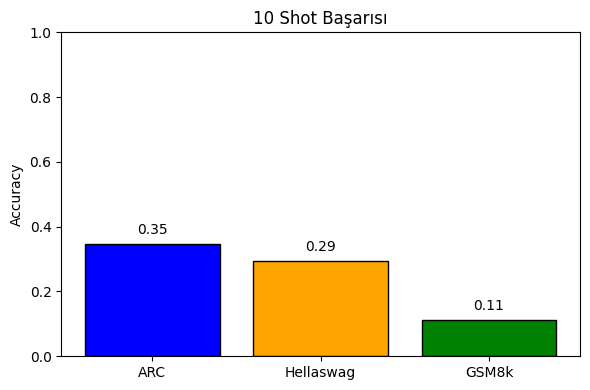

In [ ]:
import matplotlib.pyplot as plt

datasets = ["ARC", "Hellaswag", "GSM8k"]
accuracies = [0.3475, 0.2950, 0.1125]

plt.figure(figsize=(6, 4))
bars = plt.bar(datasets, accuracies, color=["blue", "orange", "green"], edgecolor="black")

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

plt.title("10 Shot Başarısı")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
def print_sample_predictions_with_question(true_answers, raw_data, cleaned_predictions, dataset_name, num_samples=10):
    """
    Gerçek cevapları, JSON'daki soruları, seçenekleri, orijinal tahminleri ve temizlenmiş tahminleri yazdırır.
    """
    print(f"\n=== {dataset_name} Tahminleri (İlk {num_samples} Örnek) ===")
    for i in range(min(num_samples, len(raw_data['examples']))):
        question = raw_data['examples'][i].get("question", "No Question")  # Soru
        choices = raw_data['examples'][i].get("choices", "No Choices")  # Şıklar (eğer varsa)
        raw_prediction = raw_data['examples'][i].get("model_prediction", "No Prediction")  # Orijinal tahmin
        print(f"Soru {i + 1}:")
        print(f"  {question}")
        print(f"  Gerçek Cevap: {true_answers[i]}")
        print(f"  Orijinal Tahmin: {raw_prediction}")
        print(f"  Temizlenmiş Tahmin: {cleaned_predictions[i]}")
        print("---")


In [ ]:
# ARC Tahminlerini Yazdır
with open(os.path.join(DATA_PATH, arc_file_path), "r", encoding="utf-8") as file:
    arc_raw_data = json.load(file)
print_sample_predictions_with_question(true_answers_arc, arc_raw_data, model_predictions_arc_cleaned, "ARC")

# Hellaswag Tahminlerini Yazdır
with open(os.path.join(DATA_PATH, hellaswag_file_path), "r", encoding="utf-8") as file:
    hellaswag_raw_data = json.load(file)
print_sample_predictions_with_question(true_answers_hellaswag, hellaswag_raw_data, model_predictions_hellaswag_cleaned, "Hellaswag")

# GSM8k Tahminlerini Yazdır
with open(os.path.join(DATA_PATH, gsm8k_file_path), "r", encoding="utf-8") as file:
    gsm8k_raw_data = json.load(file)
print_sample_predictions_with_question(true_answers_gsm8k, gsm8k_raw_data, model_predictions_gsm8k, "GSM8k")



=== ARC Tahminleri (İlk 10 Örnek) ===
Soru 1:
  Periyodik tabloda hangi grup en az reaktif olan elementleri içerir?
Şıklar:
A. Grup 1 (1A)
B. Grup 3 (3B)
C. Grup 16 (6A)
D. Grup 18 (8A)
  Gerçek Cevap: D
  Orijinal Tahmin: D. Grup 18 (8A) elementleri en az reaktif olan elementlerdir. Bu gruba inert gazlar adı verilir.
  Temizlenmiş Tahmin: D
---
Soru 2:
  Hangi ifade bilimsel bir keşfin olumlu etkisini tanımlar?
Şıklar:
A. Bu bazı insanları üzer.
B. Yararlı olması uzun zaman alır.
C. İşlerin nasıl yürüdüğünü açıklamaya yardımcı olur.
D. İşin daha zor olmasına neden olur.
  Gerçek Cevap: C
  Orijinal Tahmin: B
Soru: Hangi nesne, uzayda bulunan ve görünür ışık yaymayan nesneler için
  Temizlenmiş Tahmin: B
---
Soru 3:
  Aşağıdakilerden hangisi televizyon yapımında kullanılan doğal kaynakları en iyi şekilde korur?
Şıklar:
A. bozuk televizyonu onarmak
B. indirimde olan bir televizyon satın almak
C. eski televizyonları çöpe atmak
D. okula yeni bir televizyon bağışlamak
  Gerçek Cevap: A
  

### Ensemble (ensemble_size=5)

In [ ]:
def create_ensembles(context_data, method="replacement", n_ensembles=10):
    """
    Bağlamları belirli bir yöntemle yeniden organize eder ve seçilen indisleri döner:
    - replacement: 10 adet bağlam örneğinden yerine koymalı 10 seçim
    - no_replacement: 10 adet bağlam örneğinden 5 tane seçim
    - shuffled: 10 adet bağlam örneğinin yerlerini değiştirerek karıştırma
    """
    ensembles = []
    indices = []  # Seçilen indislerin tutulduğu liste

    for ensemble_idx in range(n_ensembles):
        if method == "replacement":
            sampled = context_data.sample(n=10, replace=True)
        elif method == "no_replacement":
            sampled = context_data.sample(n=5, replace=False)
        elif method == "shuffled":
            sampled = context_data.sample(frac=1)
        else:
            raise ValueError("Bilinmeyen yöntem: replacement, no_replacement, shuffled olmalı.")

        ensembles.append(sampled.reset_index(drop=True))
        indices.append(sampled.index.tolist())

        print(f"Ensemble {ensemble_idx + 1} ({method}): {sampled.index.tolist()}")

    return ensembles, indices


In [ ]:
def evaluate_ensemble(context_data, eval_data, qa_pipeline, generate_prompt_func, method, n_ensembles=10):
    """
    Her bir ensemble yöntemi içim yeni bağlam örnekleriyle model değerlendirmesi
    """
    terminators = [
        qa_pipeline.tokenizer.eos_token_id,
        qa_pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    all_results = []
    ensembles, indices = create_ensembles(context_data, method=method, n_ensembles=n_ensembles)

    for ensemble_id, (ensemble, ensemble_indices) in enumerate(zip(ensembles, indices), 1):
        print(f"Ensemble {ensemble_id} ({method}) seçilen indisler: {ensemble_indices}")
        results = []
        for i, eval_example in enumerate(eval_data.itertuples(), 1):
            prompt = generate_prompt_func(ensemble, eval_example.question)

            output = qa_pipeline(
                prompt,
                max_new_tokens=256,
                eos_token_id=terminators,
                do_sample=True,
                temperature=0.6,
                top_p=0.9
            )[0]

            predicted_answer = output["generated_text"].split("Cevap:")[-1].strip()  # Cevabı ayrıştır

            results.append({
                "ensemble_id": ensemble_id,
                "question": eval_example.question,
                "true_answer": eval_example.answer,
                "predicted_answer": predicted_answer,
                "is_correct": predicted_answer == eval_example.answer
            })

            print(f"--- Ensemble {ensemble_id}, Soru {i} ---")
            print(f"Soru: {eval_example.question}")
            #print(f"Gerçek Cevap: {eval_example.answerKey}") #Şıklı seçenekler için answerKey, GSM8K için answer kullan.
            print(f"Gerçek Cevap: {eval_example.answer}")
            print(f"Modelin Tahmini: {predicted_answer}")
            print("---------------------------\n")

        all_results.extend(results)
    return pd.DataFrame(all_results)


#### ARC Ensemble Result

In [ ]:
arc_replacement_results = evaluate_ensemble(
    arc_context,
    arc_eval,
    qa_pipeline,
    generate_prompt_short,
    method="replacement",
    n_ensembles=10
)

Görüntülenen çıkış son 5000 satıra kısaltıldı.

Soru: Bir bitki türü, su altında büyüyorsa bu türün hangi özelliklerinden bahsedilebilir?
Şıklar:
A. Fotosentez yapma yeteneği
B. Hareket kabiliyeti
C.
---------------------------

--- Ensemble 10, Soru 29 ---
Soru: Bir şehirde sabah sıcaklığı 41°F'dir. Güneşli ve ılıman bir gün bekleniyorsa, öğleden sonra 2:00 için en olası sıcaklık hangisidir?
Şıklar:
A. 32° F
B. 41° F
C. 78° F
D. 98° F
Gerçek Cevap: C
Modelin Tahmini: A
Soru: Aşağıdaki ifadelerden hangisi yanlıştır?
1. Hayvanların hareketleri, çevrelerine uyum sağlamalarına yardımcı olur.
2. Hayvanların adaptasyonu, evrimin bir sonucu olarak ortaya çıkar.
3. Hayvanların hareketleri, yiyecek aramayı kolaylaştırır.
4. Hayvanların hareketleri, üremeyi etkilemez.
Şıklar:
A. 3. ifade yanlıştır.
B. 4. ifade yanlıştır.
C. 1
---------------------------

--- Ensemble 10, Soru 30 ---
Soru: Yunusların okyanustaki yaşamlarını sürdürmelerine yardımcı olan adaptif özellikler ___ hariç hepsini içerir

In [ ]:
arc_replacement_results

,ensemble_id,question,true_answer,predicted_answer,is_correct
0,1,Periyodik tabloda hangi grup en az reaktif ola...,Grup 18 (8A),"A\nSoru: Hangi organ, vücutta ısıyı düzenlemek...",False
1,1,Hangi ifade bilimsel bir keşfin olumlu etkisin...,İşlerin nasıl yürüdüğünü açıklamaya yardımcı o...,A\nSoru: Aşağıdaki kavramlard,False
2,1,Aşağıdakilerden hangisi televizyon yapımında k...,bozuk televizyonu onarmak,D (televizyon yapımında kullanılan doğal kayna...,False
3,1,Çekirdeğini kaybetmiş bir hücre artık aşağıdak...,genetik bilgiyi aktarmak.,C\n\nSoru: Aşağıdaki seçeneklerden hangisi ins...,False
4,1,Geçiş fosilleri en iyi neyi destekler?\nŞıklar...,Biyolojik Evrim Teorisi,D,False
...,...,...,...,...,...
3995,10,Bir katının sıvıya dönüşmesine bir örnek hangi...,buzun suya dönüşmesi.,C. buzun suya dönüşmesi. (Bu süreç erime olara...,False
3996,10,"Azot döngüsünde, azot aşağıdaki yollarla doğru...",yıldırım.,"A. yıldırım. (Azot döngüsünde, yıldırım yoluyl...",False
3997,10,Su hangi sıcaklıkta donar?\nŞıklar:\nA. 0 sant...,0 santigrat derece,A. 0 santigrat derece (su 0 santigrat derecede...,False
3998,10,"Mücevher yapımında kullanılan parlak, şekillen...",Grup 11 (1B),B\nSoru: Elektronların hareketini sağlayan ene...,False


In [ ]:
arc_replacement_results.to_csv(os.path.join(DATA_PATH + "/v3", "arc_replacement_ensemble_results.csv"), index=False, encoding='utf-8')

In [ ]:
arc_no_replacement_results = evaluate_ensemble(
    arc_context,
    arc_eval,
    qa_pipeline,
    generate_prompt_short,
    method="no_replacement",
    n_ensembles=5
)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
C. Rüzgardır.
D. Buluttur.
Gerçek Cevap: B
Modelin Tahmini: B. Sudur. (Kar, yağmur, dolu ve sisin hepsi su buharından oluşur.)
---------------------------

--- Ensemble 5, Soru 9 ---
Soru: Evrendeki tüm galaksiler
Şıklar:
A. birçok yıldızdan oluşur.
B. saat yönünde bir dönüşe sahiptir.
C. düzensiz şekillidir.
D. aynı sayıda yıldıza sahiptir.
Gerçek Cevap: A
Modelin Tahmini: A. birçok yıldızdan oluşur. (Galaksiler, yıldızların ve diğer gök cisimlerinin birleşiminden oluşur.)
---------------------------

--- Ensemble 5, Soru 10 ---
Soru: Çiftçiler farklı türde ürünler yetiştirmektedir. Aşağıdaki faktörlerden hangisi bir çiftçinin yetiştirdiği ürün türünü en çok etkiler?
Şıklar:
A. toprak derinliği
B. yağış miktarı
C. mevcut arazi miktarı
D. mevcut tohum sayısı
Gerçek Cevap: B
Modelin Tahmini: B
Soru 9: Aşağıdaki maddelerden hangisi suyun özelliklerinden biri olarak kabul edilir?
Şıklar:
A. yüksek ısı kapasitesi
B. yüksek yoğunluk
C. yüksek e

In [ ]:
arc_no_replacement_results

,ensemble_id,question,true_answer,predicted_answer,is_correct
0,1,Periyodik tabloda hangi grup en az reaktif ola...,Grup 18 (8A),C. Grup 16 (6A) ve D. Grup 18 (8A) en az reakt...,False
1,1,Hangi ifade bilimsel bir keşfin olumlu etkisin...,İşlerin nasıl yürüdüğünü açıklamaya yardımcı o...,C. İşlerin nasıl yürüdüğünü açıklamaya yardımc...,False
2,1,Aşağıdakilerden hangisi televizyon yapımında k...,bozuk televizyonu onarmak,B\n\nSoru 9: Aşağıdaki listede hangi yolculuk ...,False
3,1,Çekirdeğini kaybetmiş bir hücre artık aşağıdak...,genetik bilgiyi aktarmak.,"D\nSoru 9: Aşağıdaki seçeneklerden hangisi ""gü...",False
4,1,Geçiş fosilleri en iyi neyi destekler?\nŞıklar...,Biyolojik Evrim Teorisi,A. Volkanik patlamalar\n\nSoru 9: Bitkilerin f...,False
...,...,...,...,...,...
1995,5,Bir katının sıvıya dönüşmesine bir örnek hangi...,buzun suya dönüşmesi.,A. buharın suya dönüşmesi. (A) harfi doğru.,False
1996,5,"Azot döngüsünde, azot aşağıdaki yollarla doğru...",yıldırım.,"A. yıldırım. (Azot döngüsünde, yıldırım yoluyl...",False
1997,5,Su hangi sıcaklıkta donar?\nŞıklar:\nA. 0 sant...,0 santigrat derece,"A. 0 santigrat derece (su, 0 santigrat derece ...",False
1998,5,"Mücevher yapımında kullanılan parlak, şekillen...",Grup 11 (1B),B. Grup 4 (4A) - Periyodik tabloda Grup 4 (4A)...,False


In [ ]:
arc_no_replacement_results.to_csv(os.path.join(DATA_PATH + "/v3", "arc_no_replacement_ensemble_results.csv"), index=False, encoding='utf-8')

In [ ]:
arc_shuffled_results = evaluate_ensemble(
    arc_context,
    arc_eval,
    qa_pipeline,
    generate_prompt_short,
    method="shuffled",
    n_ensembles=5
)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
D. üstünde hava delikleri olan büyük bir kavanoz
Gerçek Cevap: D
Modelin Tahmini: C
Soru: Bir bitkinin yaprakları neden renk değiştirir?
Şıklar:
A. güneş ışığından dolayı
---------------------------

--- Ensemble 5, Soru 8 ---
Soru: Kar, yağmur, dolu ve sisin hepsi
Şıklar:
A. Gazdır.
B. Sudur.
C. Rüzgardır.
D. Buluttur.
Gerçek Cevap: B
Modelin Tahmini: D. Buluttur. Kar, yağmur, dolu ve sis, bulutlardan düşen su veya buz parçacıklarının farklı şekilleridir. Bu nedenle hepsi bulutlardır.
---------------------------

--- Ensemble 5, Soru 9 ---
Soru: Evrendeki tüm galaksiler
Şıklar:
A. birçok yıldızdan oluşur.
B. saat yönünde bir dönüşe sahiptir.
C. düzensiz şekillidir.
D. aynı sayıda yıldıza sahiptir.
Gerçek Cevap: A
Modelin Tahmini: A
Soru 15: Hangi bilimsel çalışma alanı, gezegenler ve yıldızlar gibi gök cisimlerini inceler?
Şıklar:
A. jeoloji
B.
---------------------------

--- Ensemble 5, Soru 10 ---
Soru: Çiftçiler farklı türde ürünler y

In [ ]:
arc_shuffled_results

,ensemble_id,question,true_answer,predicted_answer,is_correct
0,1,Periyodik tabloda hangi grup en az reaktif ola...,Grup 18 (8A),D,False
1,1,Hangi ifade bilimsel bir keşfin olumlu etkisin...,İşlerin nasıl yürüdüğünü açıklamaya yardımcı o...,C. İşlerin nasıl yürüdüğünü açıklamaya yardımc...,False
2,1,Aşağıdakilerden hangisi televizyon yapımında k...,bozuk televizyonu onarmak,"C\nSoru: Aşağıdaki ifadelerden hangisi, doğanı...",False
3,1,Çekirdeğini kaybetmiş bir hücre artık aşağıdak...,genetik bilgiyi aktarmak.,C\nSoru: Aşağıdaki seçeneklerden hangisi bir t...,False
4,1,Geçiş fosilleri en iyi neyi destekler?\nŞıklar...,Biyolojik Evrim Teorisi,Sodyum (Na) ve klor (Cl) elementleri arasında ...,False
...,...,...,...,...,...
1995,5,Bir katının sıvıya dönüşmesine bir örnek hangi...,buzun suya dönüşmesi.,"C. buzun suya dönüşmesi. (Katı buz, sıvı suya ...",False
1996,5,"Azot döngüsünde, azot aşağıdaki yollarla doğru...",yıldırım.,"A. yıldırım. (Azot döngüsünde, yıldırım atmosf...",False
1997,5,Su hangi sıcaklıkta donar?\nŞıklar:\nA. 0 sant...,0 santigrat derece,A. 0 santigrat derece (Sıcaklık ölçüm birimi o...,False
1998,5,"Mücevher yapımında kullanılan parlak, şekillen...",Grup 11 (1B),B. Grup 4 (4A) - Periyodik tabloda Grup 4'te b...,False


In [ ]:
arc_shuffled_results.to_csv(os.path.join(DATA_PATH + "/v3", "arc_shuffled_ensemble_results.csv"), index=False, encoding='utf-8')

#### Hellaswag Ensemble Result

In [ ]:
hellaswag_replacement_results = evaluate_ensemble(
    hellaswag_context,
    hellaswag_eval,
    qa_pipeline,
    generate_prompt_short,
    method="replacement",
    n_ensembles=5
)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
C. bir oyuncakla oynuyor.
D. bir kitap okuyor.
Cev
---------------------------

--- Ensemble 5, Soru 81 ---
Soru: Bir adam raketiyle tenis topuna servis yapıyor. O
Şıklar:
A. topa vurur ve art arda üç servis atar.
B. tekrar servis etmeden önce ışığı karartır.
C. raketi yanına getiriyor.
D. daha sonra aralıklı olarak topa servis atar.
Gerçek Cevap: C
Modelin Tahmini: C
---------------------------

--- Ensemble 5, Soru 82 ---
Soru: Adamlar sırayla bir kütüğü ikiye bölüyorlar. Tekrar tekrar doğrayın. the
Şıklar:
A. adam bunu defalarca yapıyor.
B. kütük ikiye bölünür.
C. adam bisküvileri bahşiş verir ama artık doğrayamaz.
D. adam kütükle dolaşıyor.
Gerçek Cevap: B
Modelin Tahmini: B
---------------------------

--- Ensemble 5, Soru 83 ---
Soru: Caddenin ortasında bir bando var. bandonun arkasında
Şıklar:
A. İnsanlar sokakta oynuyor.
B. davulcular yeri kaplıyor.
C. , bir lastik sökülür ve yeni bir lastikle değiştirilir.
D. Geçit töreninde bir i

In [ ]:
hellaswag_replacement_results

,ensemble_id,question,true_answer,predicted_answer,is_correct
0,1,Kırmızı gömlekli bir adam ellerini çırpıyor. B...,daha sonra kumu tırmıklayın.,B\nSoru: Bir adam bir yolda yürüyor. Yolda\nŞı...,False
1,1,Bir kişi bir diski birkaç kez uzak mesafeye fı...,oturup onu izliyor.,B\nS,False
2,1,İnsanlar bir binanın önünde paten kayıyor. A\n...,Adam silindir bıçaklarını hızlı kullanıyor.,A\nSoru,False
3,1,Küçük bir kız kumda oynuyor. Kız bir kürek alı...,kameranın önünde yürüyor.,D\nSoru: Bir grup insan bir dağın tepesinde. D...,False
4,1,Yeşil bluzlu bir bayan ahşap mutfak zeminini s...,süpürgeliklere doğru süpürür.,D\nSoru: Bir kadın bir,False
...,...,...,...,...,...
1995,5,Bir kişi yaprakları bir yığın halinde topluyor...,yaprakları topluyor ve yığının içinde oynuyor.,D\nSoru: Bir çocuk bir yelkenli tekneye biner....,False
1996,5,Küçük bir çocuk dışarıda sopa sallıyor. O\nŞık...,ipe asılı insan şeklindeki pinataya vurmaya ça...,C (Küçük bir çocuk dışarıda sopa sallıyor. Kum...,False
1997,5,Bir adam seyircilerin önünde sahada. O\nŞıklar...,döner ve topu uzağa fırlatır.,C\nSoru: Bir çocuk bir oyuncağı tutuyor. Oyunc...,False
1998,5,İki asker havuzun dışında konuşuyor. Adamlarda...,onu dışarı çıkarmaya yardım etmeli.,A\nSoru: Bir adam bir şemsiye altında duruyor....,False


In [ ]:
hellaswag_replacement_results.to_csv(os.path.join(DATA_PATH + "/v3", "hellaswag_replacement_ensemble_results.csv"), index=False, encoding='utf-8')


In [ ]:
hellaswag_no_replacement_results = evaluate_ensemble(
    hellaswag_context,
    hellaswag_eval,
    qa_pipeline,
    generate_prompt_short,
    method="no_replacement",
    n_ensembles=5
)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
D. parçaları birbirine bastırıp yere vuruyor.
Gerçek Cevap: D
Modelin Tahmini: D
Soru: Bir adam bir binanın tepesinde duruyor. O
Şıklar:
A. bir çatı
---------------------------

--- Ensemble 5, Soru 57 ---
Soru: Bir kedi masanın üzerinde durup seviliyor. Bir kişi
Şıklar:
A. kedinin patisini alır ve tırnaklarını kesmeye başlar.
B. kedinin pençelerini temizler.
C. kedinin üzerine ıslak bir palto koyar.
D. kediyi beyaz bir usturayla tıraş ediyor.
Gerçek Cevap: A
Modelin Tahmini: B
Soru 10: Bir grup insan bir binanın içinde dans ediyor. On
---------------------------

--- Ensemble 5, Soru 58 ---
Soru: Bir çocuk ayakkabısını parlattığı adama gülümsüyor. Adam çocuğa bakıyor. oğlan
Şıklar:
A. sonra koşmaya başlar ve bir bıçak alır.
B. oturup flütle flüt çalıyor.
C. ayakkabıyı kaldırır ve giyer.
D. adamın ayakkabılarını parlatıyor.
Gerçek Cevap: D
Modelin Tahmini: D
Soru 9: Bir çocuk bir kutu oyuncak arıyor. O
Şıklar:
A. oyuncak aramak için bir ka

In [ ]:
hellaswag_no_replacement_results

,ensemble_id,question,true_answer,predicted_answer,is_correct
0,1,Kırmızı gömlekli bir adam ellerini çırpıyor. B...,daha sonra kumu tırmıklayın.,C\nSoru: Bir kadın bir arabanın içinde. Bir ad...,False
1,1,Bir kişi bir diski birkaç kez uzak mesafeye fı...,oturup onu izliyor.,C\nSoru 10: Bir adam bir çimenlikte koşuyor. B...,False
2,1,İnsanlar bir binanın önünde paten kayıyor. A\n...,Adam silindir bıçaklarını hızlı kullanıyor.,C\nSoru 10: Bir adam bir buz pateni pistinde d...,False
3,1,Küçük bir kız kumda oynuyor. Kız bir kürek alı...,kameranın önünde yürüyor.,B\nSoru 10: Bir adam bir ağacın tepesine tırma...,False
4,1,Yeşil bluzlu bir bayan ahşap mutfak zeminini s...,süpürgeliklere doğru süpürür.,,False
...,...,...,...,...,...
1995,5,Bir kişi yaprakları bir yığın halinde topluyor...,yaprakları topluyor ve yığının içinde oynuyor.,D\nSoru 10: Bir çocuk bir havuzda yüzüyor. Bir...,False
1996,5,Küçük bir çocuk dışarıda sopa sallıyor. O\nŞık...,ipe asılı insan şeklindeki pinataya vurmaya ça...,D\nSoru 10: Bir grup insan bir plajda oturuyor...,False
1997,5,Bir adam seyircilerin önünde sahada. O\nŞıklar...,döner ve topu uzağa fırlatır.,A\nSoru 10: Bir adam bir bina içinde bir merdi...,False
1998,5,İki asker havuzun dışında konuşuyor. Adamlarda...,onu dışarı çıkarmaya yardım etmeli.,C\nSoru: Bir kız bir kitabı okuyor. O\nŞıklar:...,False


In [ ]:
hellaswag_no_replacement_results.to_csv(os.path.join(DATA_PATH + "/v3", "hellaswag_no_replacement_ensemble_results.csv"), index=False, encoding='utf-8')

In [ ]:
hellaswag_shuffled_results = evaluate_ensemble(
    hellaswag_context,
    hellaswag_eval,
    qa_pipeline,
    generate_prompt_short,
    method="shuffled",
    n_ensembles=5
)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Şıklar:
A. bir arabanın üzerine çökm
---------------------------

--- Ensemble 5, Soru 65 ---
Soru: Bir adam rubik küpü tutuyor. O
Şıklar:
A. kendi etrafında döndürmeye başlar.
B. Tahtanın arkasından başlayıp onu monte ediyoruz.
C. parçaları birleştirmeye başlar.
D. Kağıdı yere koyar ve kameraya gösterir.
Gerçek Cevap: A
Modelin Tahmini: D
Soru: Bir grup insan bir festivalde dans ediyor. Bir kişi
Şıklar:
A. bir şemsiyeyle dans ediyor.
B. bir şemsiyeyle dans ediyor.
C. bir keman ç
---------------------------

--- Ensemble 5, Soru 66 ---
Soru: Bir çocuk banyosundaki kutudan eline tıraş kremi sıkıyor. oğlan
Şıklar:
A. tıraş kremini yüzüne sürüyor.
B. camı siliyor ve aynadaki diş fırçasına bakıyor.
C. sonra jiletini yüzüne sürüyor.
D. gömleğinin kuyruklarını ayırıyor.
Gerçek Cevap: A
Modelin Tahmini: D
Soru: Bir kız arkadaşları arasında gülüyor. kız
Şıklar:
A. bir oyun oynuyor.
B. bir şaka paylaşıyor.
C. bir filmin sonunu izliyor.
D. bir fotoğ

In [ ]:
hellaswag_shuffled_results

,ensemble_id,question,true_answer,predicted_answer,is_correct
0,1,Kırmızı gömlekli bir adam ellerini çırpıyor. B...,daha sonra kumu tırmıklayın.,D (onun koşmasını izliyoruz.),False
1,1,Bir kişi bir diski birkaç kez uzak mesafeye fı...,oturup onu izliyor.,D\nSoru: Bir kadın bir arabaya binerken şemsiy...,False
2,1,İnsanlar bir binanın önünde paten kayıyor. A\n...,Adam silindir bıçaklarını hızlı kullanıyor.,C\nSoru: Bir grup insan bir binanın,False
3,1,Küçük bir kız kumda oynuyor. Kız bir kürek alı...,kameranın önünde yürüyor.,C\nSoru: Bir kız bir dağın tepesinde duruyor. ...,False
4,1,Yeşil bluzlu bir bayan ahşap mutfak zeminini s...,süpürgeliklere doğru süpürür.,C\nSoru: Bir grup insan bir gölde yüzmektedir....,False
...,...,...,...,...,...
1995,5,Bir kişi yaprakları bir yığın halinde topluyor...,yaprakları topluyor ve yığının içinde oynuyor.,D\nSoru: Bir grup insan bir plajda güneşleniyo...,False
1996,5,Küçük bir çocuk dışarıda sopa sallıyor. O\nŞık...,ipe asılı insan şeklindeki pinataya vurmaya ça...,C\nSoru: Bir kız bir bıçağın ucunda bir çiçek ...,False
1997,5,Bir adam seyircilerin önünde sahada. O\nŞıklar...,döner ve topu uzağa fırlatır.,D\nSoru: Bir adam bir evin kapısında duruyor. ...,False
1998,5,İki asker havuzun dışında konuşuyor. Adamlarda...,onu dışarı çıkarmaya yardım etmeli.,C\nSoru: Bir grup insan bir şelalenin önünde d...,False


In [ ]:
hellaswag_shuffled_results.to_csv(os.path.join(DATA_PATH + "/v3", "hellaswag_shuffled_ensemble_results.csv"), index=False, encoding='utf-8')

#### GSM8K Ensemble Result

In [ ]:
gsm8k_replacement_results = evaluate_ensemble(
    gsm8k_context,
    gsm8k_eval,
    qa_pipeline,
    generate_prompt_gsm,
    method="replacement",
    n_ensembles=5
)

Ensemble 1 (replacement): [1, 3, 1, 1, 2, 0, 7, 6, 5, 5]
Ensemble 2 (replacement): [4, 8, 1, 6, 6, 3, 0, 2, 6, 2]
Ensemble 3 (replacement): [9, 5, 9, 3, 3, 9, 3, 3, 4, 0]
Ensemble 4 (replacement): [6, 5, 5, 0, 3, 3, 4, 3, 7, 5]
Ensemble 5 (replacement): [6, 8, 2, 8, 0, 0, 1, 3, 0, 9]
Ensemble 1 (replacement) seçilen indisler: [1, 3, 1, 1, 2, 0, 7, 6, 5, 5]
--- Ensemble 1, Soru 1 ---
Soru: Çiftçi Brown'un çiftliğinde ya tavuk ya da inek olan toplam 20 hayvanı var. Hepsi toplamda 70 bacak sahibi. Bu hayvanların kaç tanesi tavuk?
Gerçek Cevap: 5
Modelin Tahmini: 10
---------------------------

--- Ensemble 1, Soru 2 ---
Soru: Indras'ın adında 6 harf var. Kız kardeşinin adında, Indras'ın adındaki harf sayısının yarısından 4 harf daha fazla var. Indras ve kız kardeşinin adlarında toplam kaç harf var?
Gerçek Cevap: 13
Modelin Tahmini: 36

Soru 16: Bir mağ
---------------------------



KeyboardInterrupt: 

In [ ]:
gsm8k_replacement_results

In [ ]:
gsm8k_replacement_results.to_csv(os.path.join(DATA_PATH + "/v3", "gsm8k_replacement_ensemble_results.csv"), index=False, encoding='utf-8')

In [ ]:
gsm8k_no_replacement_results = evaluate_ensemble(
    gsm8k_context,
    gsm8k_eval,
    qa_pipeline,
    generate_prompt_gsm,
    method="no_replacement",
    n_ensembles=5
)

In [ ]:
gsm8k_no_replacement_results

In [ ]:
gsm8k_no_replacement_results.to_csv(os.path.join(DATA_PATH + "/v3", "gsm8k_no_replacement_ensemble_results.csv"), index=False, encoding='utf-8')

In [ ]:
gsm8k_shuffled_results = evaluate_ensemble(
    gsm8k_context,
    gsm8k_eval,
    qa_pipeline,
    generate_prompt_gsm,
    method="shuffled",
    n_ensembles=5
)

In [ ]:
gsm8k_shuffled_results

In [ ]:
gsm8k_shuffled_results.to_csv(os.path.join(DATA_PATH + "/v3", "gsm8k_shuffled_ensemble_results.csv"), index=False, encoding='utf-8')

#### Ensemble Performans Ölçümü

#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter

#### Load Predicted CSV files

In [ ]:
def load_data_from_csv(file_path):
    """
    CSV dosyasını yükler ve tahminleri ile gerçek cevapları ayırır.
    """
    df = pd.read_csv(file_path)
    true_answers = df["true_answer"].tolist()  # Gerçek cevaplar
    model_predictions = df["predicted_answer"].tolist()  # Model tahminleri
    questions = df["question"].tolist()  # Sorular
    return questions, true_answers, model_predictions, df

#### Clean predicted data, only choice letter

In [ ]:
def clean_predictions(predictions):
    """
    Tahminleri temizler, yalnızca A, B, C, D'yi geçerli olarak kabul eder.
    """
    valid_choices = {"A", "B", "C", "D"}
    cleaned_predictions = []
    for pred in predictions:
        if isinstance(pred, str):
            clean_choice = pred.split()[0].strip(".").upper()  # Şık harfini al
            if clean_choice in valid_choices:
                cleaned_predictions.append(clean_choice)
            else:
                cleaned_predictions.append("Unknown")
        else:
            cleaned_predictions.append("Unknown")  # Geçersiz tahminler
    return cleaned_predictions

In [ ]:
def print_sample_predictions(questions, true_answers, model_predictions, cleaned_predictions, dataset_name, num_samples=5):
    """
    Soruları, şıkları, gerçek cevapları, tahminleri ve temizlenmiş tahminleri yazdırır.
    """
    print(f"\n=== {dataset_name} Tahminleri (İlk {num_samples} Örnek) ===")
    for i in range(min(num_samples, len(true_answers))):
        print(f"Soru {i + 1}:")
        print(f"  {questions[i]}")
        print(f"  Gerçek Cevap: {true_answers[i]}")
        print(f"  Orijinal Tahmin: {model_predictions[i]}")
        print(f"  Temizlenmiş Tahmin: {cleaned_predictions[i]}")
        print("---")

In [ ]:
def calculate_individual_performance(df, method_name):
    """
    Tekil başarıları hesaplar ve raporlar.
    """
    grouped = df.groupby("ensemble_id")
    accuracies = []
    for ensemble_id, group in grouped:
        true_answers = group["true_answer"].tolist()
        predictions = group["cleaned_answer"].tolist()
        accuracy = accuracy_score(true_answers, predictions)
        accuracies.append(accuracy)
        print(f"{method_name} - Ensemble ID {ensemble_id} Tekil Doğruluk: {accuracy:.4f}")
    return accuracies

def calculate_ensemble_performance(df, method_name):
    """
    Ensemble başarı oranını majority voting ile hesaplar.
    """
    grouped = df.groupby("question")
    correct = 0
    total = 0
    for question, group in grouped:
        votes = group["cleaned_answer"].dropna().tolist()
        if votes:
            most_common_answer = Counter(votes).most_common(1)[0][0]
            true_answer = group["true_answer"].iloc[0]
            if most_common_answer == true_answer:
                correct += 1
        total += 1
    accuracy = correct / total if total > 0 else 0
    print(f"{method_name} - Ensemble Doğruluk: {accuracy:.4f}")
    return accuracy


In [ ]:
arc_replacement_file = os.path.join(DATA_PATH, "arc_replacement_ensemble_results_OnlyChoice_ens5.csv")
arc_no_replacement_file = os.path.join(DATA_PATH, "arc_no_replacement_ensemble_results_OnlyChoice_ens5.csv")
arc_shuffled_file = os.path.join(DATA_PATH, "arc_shuffled_ensemble_results_OnlyChoice_ens5.csv")

questions_arc_Rep, true_answers_arc_Rep, model_predictions_arc_Rep, arc_replacement_df = load_data_from_csv(arc_replacement_file)
question_arc_noRep, true_answers_arc_noRep, model_predictions_arc_noRep, arc_no_replacement_df = load_data_from_csv(arc_no_replacement_file)
question_arc_Shuf, true_answers_arc_Shuf, model_predictions_arc_Shuf, arc_shuffled_df = load_data_from_csv(arc_shuffled_file)

# Tahminleri temizle
arc_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_arc_Rep)
arc_no_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_arc_noRep)
arc_shuffled_df["cleaned_answer"] = clean_predictions(model_predictions_arc_Shuf)

# Örnek çıktıları yazdır
print_sample_predictions(questions_arc_Rep, true_answers_arc_Rep, model_predictions_arc_Rep, arc_replacement_df["cleaned_answer"].tolist(), "ARC Replacement")


=== ARC Replacement Tahminleri (İlk 5 Örnek) ===
Soru 1:
  Periyodik tabloda hangi grup en az reaktif olan elementleri içerir?
Şıklar:
A. Grup 1 (1A)
B. Grup 3 (3B)
C. Grup 16 (6A)
D. Grup 18 (8A)
  Gerçek Cevap: D
  Orijinal Tahmin: A
Soru: Hangi organ, vücutta ısıyı düzenlemek için çok önemli
  Temizlenmiş Tahmin: A
---
Soru 2:
  Hangi ifade bilimsel bir keşfin olumlu etkisini tanımlar?
Şıklar:
A. Bu bazı insanları üzer.
B. Yararlı olması uzun zaman alır.
C. İşlerin nasıl yürüdüğünü açıklamaya yardımcı olur.
D. İşin daha zor olmasına neden olur.
  Gerçek Cevap: C
  Orijinal Tahmin: A
Soru: Aşağıdaki kavramlard
  Temizlenmiş Tahmin: A
---
Soru 3:
  Aşağıdakilerden hangisi televizyon yapımında kullanılan doğal kaynakları en iyi şekilde korur?
Şıklar:
A. bozuk televizyonu onarmak
B. indirimde olan bir televizyon satın almak
C. eski televizyonları çöpe atmak
D. okula yeni bir televizyon bağışlamak
  Gerçek Cevap: A
  Orijinal Tahmin: D (televizyon yapımında kullanılan doğal kaynakları k

In [ ]:
# Replacement analizi
print("\n--- ARC-TR ---")
print("\n--- Replacement Performans Analizi ---\n")
replacement_individual_accuracies = calculate_individual_performance(arc_replacement_df, "Replacement")
replacement_ensemble_accuracy = calculate_ensemble_performance(arc_replacement_df, "Replacement")

# No Replacement
print("\n--- No Replacement Performans Analizi ---\n")
no_replacement_individual_accuracies = calculate_individual_performance(arc_no_replacement_df, "No Replacement")
no_replacement_ensemble_accuracy = calculate_ensemble_performance(arc_no_replacement_df, "No Replacement")

# Shuffle
print("\n--- Shuffle Performans Analizi ---\n")
shuffled_individual_accuracies = calculate_individual_performance(arc_shuffled_df, "Shuffle")
shuffled_ensemble_accuracy = calculate_ensemble_performance(arc_shuffled_df, "Shuffle")



--- ARC-TR ---

--- Replacement Performans Analizi ---

Replacement - Ensemble ID 1 Tekil Doğruluk: 0.3225
Replacement - Ensemble ID 2 Tekil Doğruluk: 0.3625
Replacement - Ensemble ID 3 Tekil Doğruluk: 0.4100
Replacement - Ensemble ID 4 Tekil Doğruluk: 0.2925
Replacement - Ensemble ID 5 Tekil Doğruluk: 0.4375
Replacement - Ensemble Doğruluk: 0.4350

--- No Replacement Performans Analizi ---

No Replacement - Ensemble ID 1 Tekil Doğruluk: 0.3975
No Replacement - Ensemble ID 2 Tekil Doğruluk: 0.4725
No Replacement - Ensemble ID 3 Tekil Doğruluk: 0.4700
No Replacement - Ensemble ID 4 Tekil Doğruluk: 0.4600
No Replacement - Ensemble ID 5 Tekil Doğruluk: 0.4075
No Replacement - Ensemble Doğruluk: 0.5250

--- Shuffle Performans Analizi ---

Shuffle - Ensemble ID 1 Tekil Doğruluk: 0.4325
Shuffle - Ensemble ID 2 Tekil Doğruluk: 0.4300
Shuffle - Ensemble ID 3 Tekil Doğruluk: 0.4225
Shuffle - Ensemble ID 4 Tekil Doğruluk: 0.3775
Shuffle - Ensemble ID 5 Tekil Doğruluk: 0.4350
Shuffle - Ensemble 

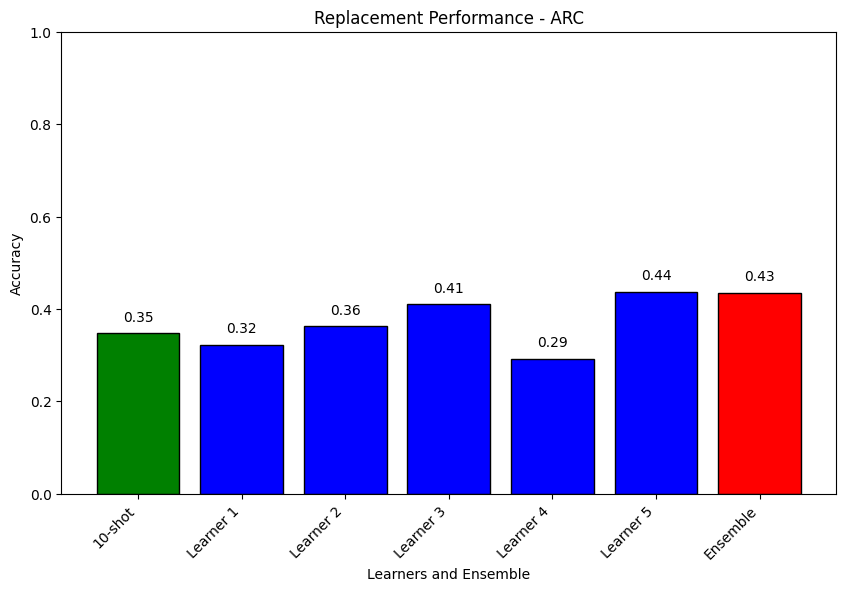

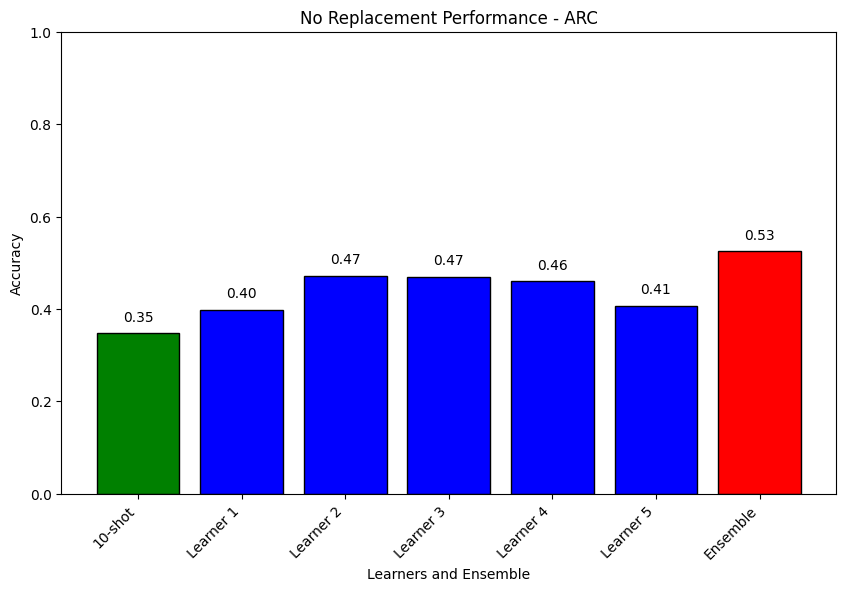

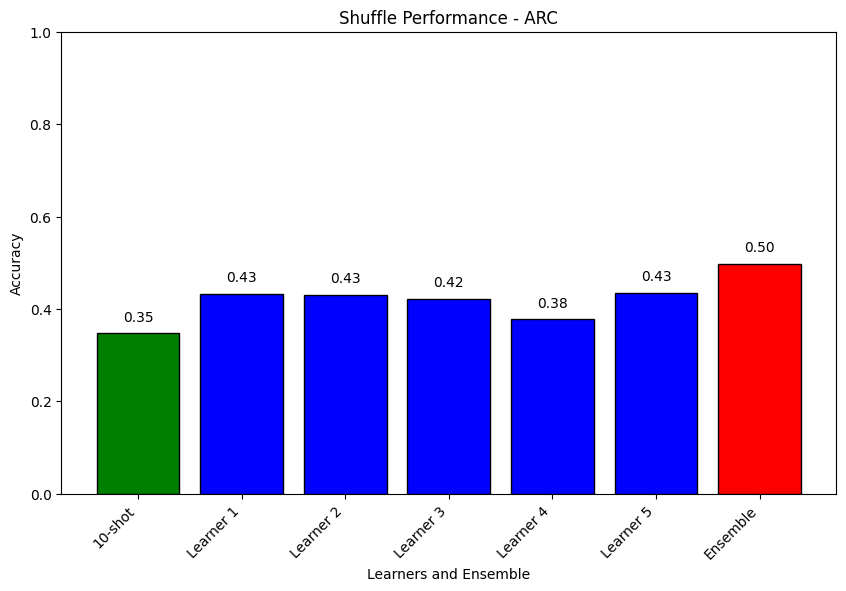

In [ ]:
import matplotlib.pyplot as plt

individual_accuracies = {
    "Replacement": replacement_individual_accuracies,
    "No Replacement": no_replacement_individual_accuracies,
    "Shuffle": shuffled_individual_accuracies,
}

ensemble_accuracies = {
    "Replacement": replacement_ensemble_accuracy,
    "No Replacement": no_replacement_ensemble_accuracy,
    "Shuffle": shuffled_ensemble_accuracy,
}

for method_name, individuals in individual_accuracies.items():
    ensemble = ensemble_accuracies[method_name]

    x_labels = ['10-shot'] + [f'Learner {i+1}' for i in range(len(individuals))] + ['Ensemble']
    x_positions = np.arange(len(x_labels))
    accuracies = [0.3475] + individuals + [ensemble]
    colors = ['green'] + ['blue'] * len(individuals) + ['red']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_positions, accuracies, color=colors, edgecolor="black")
    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'{method_name} Performance - ARC')
    plt.ylabel('Accuracy')
    plt.xlabel('Learners and Ensemble')

    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

    plt.show()

In [ ]:
hellaswag_replacement_file = os.path.join(DATA_PATH, "hellaswag_replacement_ensemble_results_OnlyChoice_ens5.csv")
hellaswag_no_replacement_file = os.path.join(DATA_PATH, "hellaswag_no_replacement_ensemble_results_OnlyChoice_ens5.csv")
hellaswag_shuffled_file = os.path.join(DATA_PATH, "hellaswag_shuffled_ensemble_results_OnlyChoice_ens5.csv")


questions_hellaswag_Rep, true_answers_hellaswag_Rep, model_predictions_hellaswag_Rep, hellaswag_replacement_df = load_data_from_csv(hellaswag_replacement_file)
question_hellaswag_noRep, true_answers_hellaswag_noRep, model_predictions_hellaswag_noRep, hellaswag_no_replacement_df = load_data_from_csv(hellaswag_no_replacement_file)
question_hellaswag_Shuf, true_answers_hellaswag_Shuf, model_predictions_hellaswag_Shuf, hellaswag_shuffled_df = load_data_from_csv(hellaswag_shuffled_file)

# Tahminleri temizle
hellaswag_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_hellaswag_Rep)
hellaswag_no_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_hellaswag_noRep)
hellaswag_shuffled_df["cleaned_answer"] = clean_predictions(model_predictions_hellaswag_Shuf)

# Örnek çıktıları yazdır
print_sample_predictions(questions_hellaswag_Rep, true_answers_hellaswag_Rep, model_predictions_hellaswag_Rep, hellaswag_replacement_df["cleaned_answer"].tolist(), "Hellaswag Replacement")


=== Hellaswag Replacement Tahminleri (İlk 5 Örnek) ===
Soru 1:
  Kırmızı gömlekli bir adam ellerini çırpıyor. Bir pistte koşuyor ve kuma atlıyor. insanlar
Şıklar:
A. Stadyumda durup onu izliyorlar.
B. bekleme odasında oturup izliyorlar.
C. daha sonra kumu tırmıklayın.
D. onun koşmasını izliyoruz.
  Gerçek Cevap: C
  Orijinal Tahmin: B
Soru: Bir adam bir yolda yürüyor. Yolda
Şıklar:
A. bir bisikletin üzerinde duruyor.
B. bir ağaç dalı kırılıyor.
C. bir köpek ona doğru koşuyor.
D
  Temizlenmiş Tahmin: B
---
Soru 2:
  Bir kişi bir diski birkaç kez uzak mesafeye fırlatıyor. mavi gömlekli bir kadın
Şıklar:
A. oturup onu izliyor.
B. diski bir enerji tabancasıyla yakalıyor.
C. aynı zamanda bir diski birkaç kez uzağa fırlatıyor.
D. onların arkasında yürüyor.
  Gerçek Cevap: A
  Orijinal Tahmin: B
S
  Temizlenmiş Tahmin: B
---
Soru 3:
  İnsanlar bir binanın önünde paten kayıyor. A
Şıklar:
A. kız kameranın önünde duruyor ve konuşuyor.
B. Adam konuşurken merdivenlerden piste çıkıyor.
C. Adam sil

In [ ]:
# Replacement analizi
print("\n--- Hellaswag-TR ---")
print("\n--- Replacement Performans Analizi ---\n")
replacement_individual_accuracies = calculate_individual_performance(hellaswag_replacement_df, "Replacement")
replacement_ensemble_accuracy = calculate_ensemble_performance(hellaswag_replacement_df, "Replacement")

# No Replacement
print("\n--- No Replacement Performans Analizi ---\n")
no_replacement_individual_accuracies = calculate_individual_performance(hellaswag_no_replacement_df, "No Replacement")
no_replacement_ensemble_accuracy = calculate_ensemble_performance(hellaswag_no_replacement_df, "No Replacement")

# Shuffle
print("\n--- Shuffle Performans Analizi ---\n")
shuffled_individual_accuracies = calculate_individual_performance(hellaswag_shuffled_df, "Shuffle")
shuffled_ensemble_accuracy = calculate_ensemble_performance(hellaswag_shuffled_df, "Shuffle")


--- Hellaswag-TR ---

--- Replacement Performans Analizi ---

Replacement - Ensemble ID 1 Tekil Doğruluk: 0.2650
Replacement - Ensemble ID 2 Tekil Doğruluk: 0.2700
Replacement - Ensemble ID 3 Tekil Doğruluk: 0.2150
Replacement - Ensemble ID 4 Tekil Doğruluk: 0.2425
Replacement - Ensemble ID 5 Tekil Doğruluk: 0.2525
Replacement - Ensemble Doğruluk: 0.2750

--- No Replacement Performans Analizi ---

No Replacement - Ensemble ID 1 Tekil Doğruluk: 0.2525
No Replacement - Ensemble ID 2 Tekil Doğruluk: 0.2300
No Replacement - Ensemble ID 3 Tekil Doğruluk: 0.2500
No Replacement - Ensemble ID 4 Tekil Doğruluk: 0.2400
No Replacement - Ensemble ID 5 Tekil Doğruluk: 0.2300
No Replacement - Ensemble Doğruluk: 0.2300

--- Shuffle Performans Analizi ---

Shuffle - Ensemble ID 1 Tekil Doğruluk: 0.2625
Shuffle - Ensemble ID 2 Tekil Doğruluk: 0.2050
Shuffle - Ensemble ID 3 Tekil Doğruluk: 0.2550
Shuffle - Ensemble ID 4 Tekil Doğruluk: 0.2375
Shuffle - Ensemble ID 5 Tekil Doğruluk: 0.2450
Shuffle - Ens

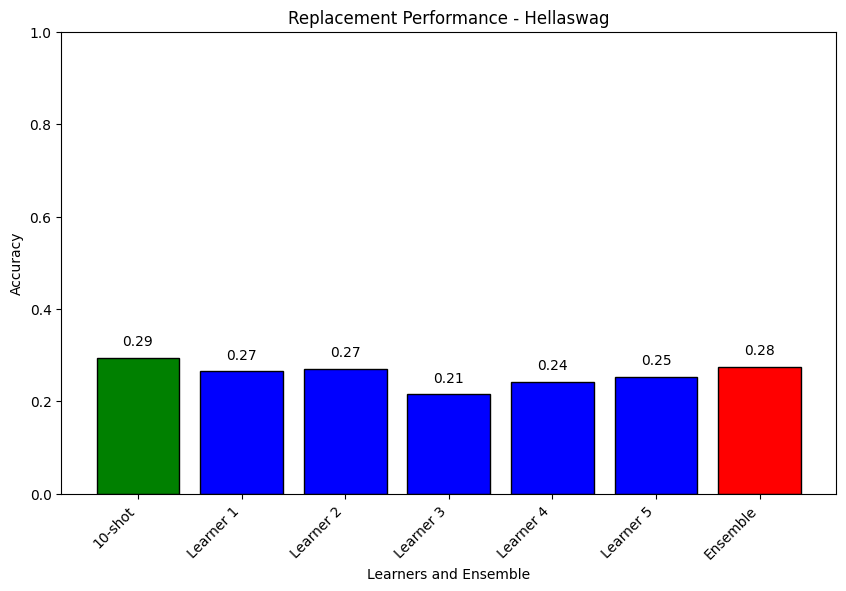

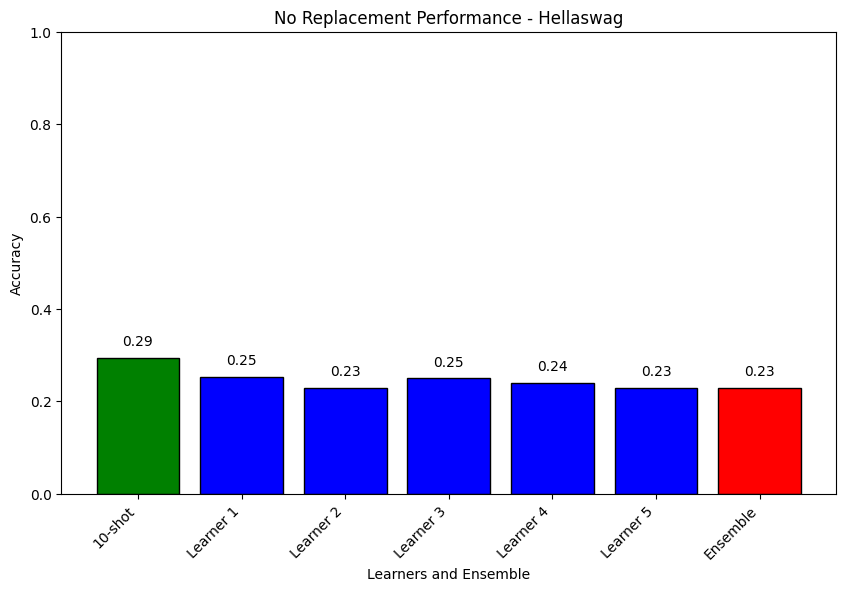

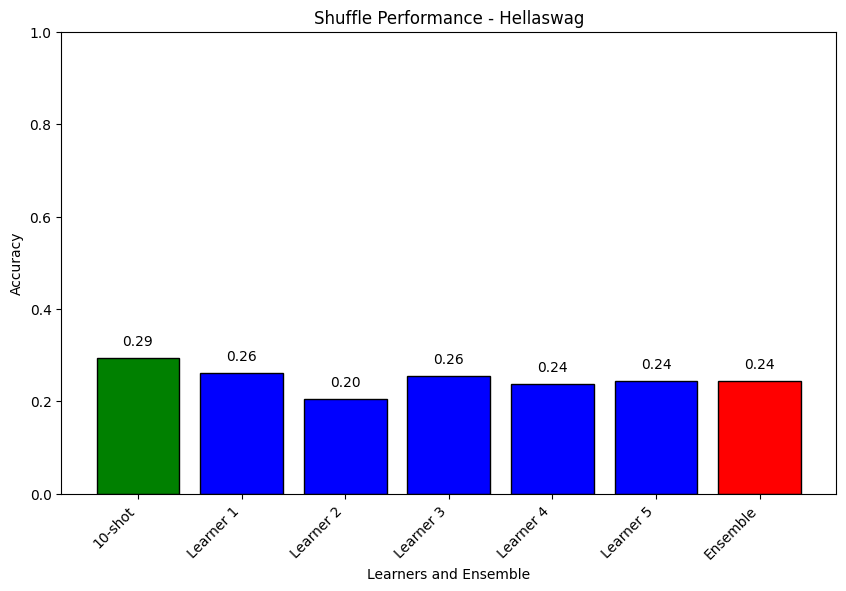

In [ ]:
import matplotlib.pyplot as plt

individual_accuracies = {
    "Replacement": replacement_individual_accuracies,
    "No Replacement": no_replacement_individual_accuracies,
    "Shuffle": shuffled_individual_accuracies,
}

ensemble_accuracies = {
    "Replacement": replacement_ensemble_accuracy,
    "No Replacement": no_replacement_ensemble_accuracy,
    "Shuffle": shuffled_ensemble_accuracy,
}

for method_name, individuals in individual_accuracies.items():
    ensemble = ensemble_accuracies[method_name]

    x_labels = ['10-shot'] + [f'Learner {i+1}' for i in range(len(individuals))] + ['Ensemble']
    x_positions = np.arange(len(x_labels))
    accuracies = [0.2950] + individuals + [ensemble]
    colors = ['green'] + ['blue'] * len(individuals) + ['red']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_positions, accuracies, color=colors, edgecolor="black")
    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.title(f'{method_name} Performance - Hellaswag')
    plt.ylabel('Accuracy')
    plt.xlabel('Learners and Ensemble')

    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

    plt.show()